<a href="https://colab.research.google.com/github/artem-dorofeev/py_DataScience_HW/blob/main/HW10_02_whith_comment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Частина 2**

В цій частині ми знову будемо працювати з датасетом fasion_mnist.


На відміну від попереднього завдання вам пропонується створити згорткову нейромережу, що використовує VGG16 в якості згорткової основи.


Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Під час навчання використовуйте прийоми донавчання та виділення ознак.


Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

*Тепер створимо згорткову нейромережу з архітектурою VGG16*

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [2]:
img_width = 32
img_height = 32

In [3]:
# Завантаження даних
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
# Підготовка даних
# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = np.repeat(train_images[..., np.newaxis], 3, -1)  # Дублюємо канали, оскільки VGG16 очікує RGB
test_images = np.repeat(test_images[..., np.newaxis], 3, -1)

train_images = train_images / 255.0
test_images = test_images / 255.0

# Додавання паддингу оскільки VGG16 очікує 32x32 (використовуэмо або ресайз або паддинг)
padding = tf.constant([[0, 0], [2, 2], [2, 2], [0, 0]])
train_images_padded = tf.pad(train_images, padding, "CONSTANT")
test_images_padded = tf.pad(test_images, padding, "CONSTANT")

# # Змінюємо розмір оскільки VGG16 очікує 32x32 (використовуэмо або ресайз або паддинг)
new_size = (img_width, img_height)
# train_images = tf.image.resize(train_images, new_size)  # Змінюємо розмір зображень до 32x32, оскільки VGG16 очікує 32x32
# test_images = tf.image.resize(test_images, new_size)

# Змінюємо розмір вхідних зображень VGG16
input_shape = (*new_size, 3)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

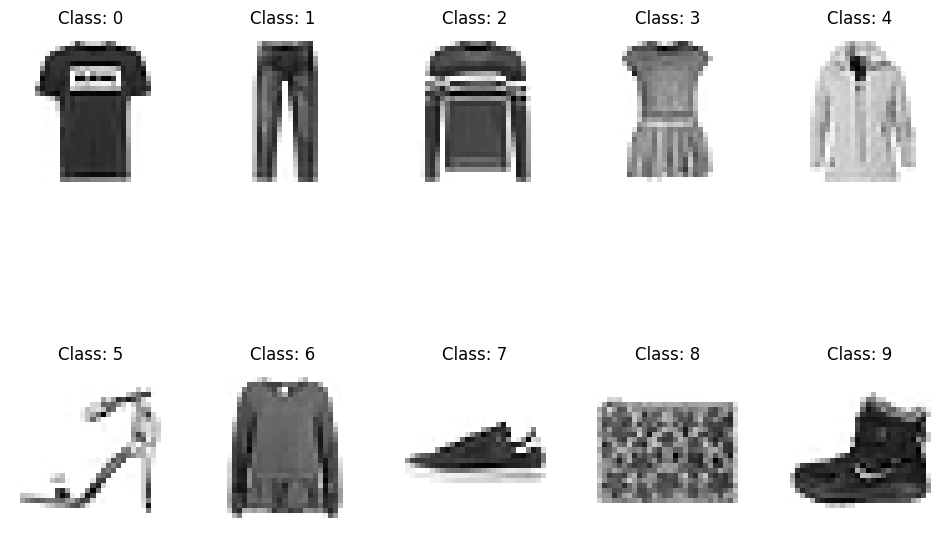

In [6]:
# Отримати унікальні класи
unique_classes = np.unique(np.argmax(train_labels, axis=1))

# Кількість стовпчиків і рядків у візуалізації
num_cols = 5
num_rows = 2

# Розмір зображення
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Показати по одному зображенню від кожного класу
for i, class_label in enumerate(unique_classes):
    # Знайти перше зображення для поточного класу
    index = np.argmax(train_labels, axis=1) == class_label

    # Отримати відповідне позначення рядка та стовпчика
    row = i // num_cols
    col = i % num_cols

    # Вибрати тільки перший канал (червоний)
    red_channel = train_images_padded[index][0][:, :, 0]

    axes[row, col].imshow(red_channel, cmap='gray_r')  # Зображення тепер чорно-біле (червоний канал)
    axes[row, col].set_title(f"Class: {class_label}")
    axes[row, col].axis('off')  # Відключення вісей для кращого вигляду

# Показати графік
plt.show()

In [7]:
train_images_padded.shape

TensorShape([60000, 32, 32, 3])

In [10]:
assert train_images_padded.shape[1:] == input_shape, f"Розміри train_images не відповідають {input_shape}"
assert test_images_padded.shape[1:] == input_shape, f"Розміри test_images не відповідають {input_shape}"


In [14]:
# Завантаження VGG16 без верхніх Dense шарів та "заморожуємо" ваги
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

# Створення згорткової мережі з використанням VGG16
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(10, activation='softmax'))

# Компіляція та навчання моделі
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()  # Вивід структури моделі


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [15]:
# Тренування моделі для train_images_padding
history_padding = model.fit(train_images_padded, train_labels, epochs=10, batch_size=256, validation_split=0.2)

# Оцінка точності на тестових даних
test_loss, test_acc = model.evaluate(test_images_padded, test_labels)
print(f'Точність на тестових даних: {test_acc}')

# Оцінка точності на тренувальних даних
train_loss, train_acc = model.evaluate(train_images_padded, train_labels)
print(f'Точність на тренувальних даних: {train_acc}')


Epoch 1/10
188/188 [==============================] - 8s 39ms/step - loss: 0.7483 - accuracy: 0.7445 - val_loss: 0.5271 - val_accuracy: 0.8096
Epoch 2/10
188/188 [==============================] - 7s 36ms/step - loss: 0.4927 - accuracy: 0.8236 - val_loss: 0.4639 - val_accuracy: 0.8332
Epoch 3/10
188/188 [==============================] - 8s 42ms/step - loss: 0.4368 - accuracy: 0.8405 - val_loss: 0.4278 - val_accuracy: 0.8463
Epoch 4/10
188/188 [==============================] - 7s 36ms/step - loss: 0.4070 - accuracy: 0.8521 - val_loss: 0.4132 - val_accuracy: 0.8497
Epoch 5/10
188/188 [==============================] - 7s 36ms/step - loss: 0.3849 - accuracy: 0.8575 - val_loss: 0.4031 - val_accuracy: 0.8519
Epoch 6/10
188/188 [==============================] - 7s 35ms/step - loss: 0.3684 - accuracy: 0.8656 - val_loss: 0.3937 - val_accuracy: 0.8589
Epoch 7/10
188/188 [==============================] - 7s 36ms/step - loss: 0.3566 - accuracy: 0.8689 - val_loss: 0.3806 - val_accuracy: 0.8599

In [19]:
model.save('model_1_hw10_02.keras')

In [18]:
# Створення згорткової мережі з використанням VGG16
model_2 = models.Sequential()
model_2.add(base_model)
model_2.add(layers.Flatten())
model_2.add(layers.Dense(256, activation='relu'))
model_2.add(layers.Dropout(0.1))
model_2.add(layers.Dense(10, activation='softmax'))

# Компіляція та налаштування EarlyStopping
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Навчання моделі з використанням Dropout та EarlyStopping
history_model_2 = model_2.fit(train_images_padded, train_labels, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Оцінка точності на тестових даних
test_loss, test_acc = model_2.evaluate(test_images_padded, test_labels)
print(f'Точність на тестових даних: {test_acc}')

# Оцінка точності на тренувальних даних
train_loss, train_acc = model_2.evaluate(train_images_padded, train_labels)
print(f'Точність на тренувальних даних: {train_acc}')

Epoch 1/50
750/750 [==============================] - 12s 14ms/step - loss: 0.6074 - accuracy: 0.7852 - val_loss: 0.4685 - val_accuracy: 0.8283
Epoch 2/50
750/750 [==============================] - 10s 13ms/step - loss: 0.4338 - accuracy: 0.8401 - val_loss: 0.4248 - val_accuracy: 0.8457
Epoch 3/50
750/750 [==============================] - 10s 13ms/step - loss: 0.3958 - accuracy: 0.8539 - val_loss: 0.3883 - val_accuracy: 0.8582
Epoch 4/50
750/750 [==============================] - 10s 13ms/step - loss: 0.3726 - accuracy: 0.8644 - val_loss: 0.3837 - val_accuracy: 0.8634
Epoch 5/50
750/750 [==============================] - 11s 14ms/step - loss: 0.3532 - accuracy: 0.8696 - val_loss: 0.3753 - val_accuracy: 0.8645
Epoch 6/50
750/750 [==============================] - 10s 14ms/step - loss: 0.3391 - accuracy: 0.8743 - val_loss: 0.3692 - val_accuracy: 0.8677
Epoch 7/50
750/750 [==============================] - 10s 13ms/step - loss: 0.3258 - accuracy: 0.8788 - val_loss: 0.3532 - val_accuracy:

In [20]:
model_2.save('model_2_hw10_02.keras')

In [26]:
train_images_padded.shape

TensorShape([60000, 32, 32, 3])

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Створення об'єкта ImageDataGenerator для донавчання та виділення ознак
datagen = ImageDataGenerator(
    rotation_range=20,  # Випадковий поворот на кут у межах 20 градусів
    width_shift_range=0.2,  # Випадковий зсув по горизонталі
    height_shift_range=0.2,  # Випадковий зсув по вертикалі
    shear_range=0.2,  # Випадковий зріз
    zoom_range=0.2,  # Випадкове масштабування
    horizontal_flip=True,  # Випадковий поворот по горизонталі
    fill_mode='nearest'  # Заповнення пікселями поблизу
)

# Донавчання моделей з використанням ImageDataGenerator
# history_model_upd = model.fit(datagen.flow(train_images_padded, train_labels, batch_size=256),
#                               epochs=10, validation_data=(test_images_padded, test_labels))

history_model_2_upd = model_2.fit(datagen.flow(train_images_padded, train_labels, batch_size=256),
                                epochs=10, validation_data=(test_images_padded, test_labels))


# Вивід результатів
# print("Результати для першої моделі після донавчання:")
# test_loss, test_acc = model.evaluate(test_images_padded, test_labels)
# print(f'Точність на тестових даних: {test_acc}')

print("Результати для другої моделі після донавчання:")
test_loss_2, test_acc_2 = model_2.evaluate(test_images_padded, test_labels)
print(f'Точність на тестових даних: {test_acc_2}')


Epoch 1/10
235/235 [==============================] - 38s 160ms/step - loss: 0.7543 - accuracy: 0.7315 - val_loss: 0.4775 - val_accuracy: 0.8252
Epoch 2/10
235/235 [==============================] - 40s 171ms/step - loss: 0.6196 - accuracy: 0.7723 - val_loss: 0.4681 - val_accuracy: 0.8361
Epoch 3/10
235/235 [==============================] - 38s 163ms/step - loss: 0.5937 - accuracy: 0.7808 - val_loss: 0.4730 - val_accuracy: 0.8281
Epoch 4/10
235/235 [==============================] - 39s 164ms/step - loss: 0.5745 - accuracy: 0.7889 - val_loss: 0.4766 - val_accuracy: 0.8309
Epoch 5/10
235/235 [==============================] - 38s 163ms/step - loss: 0.5607 - accuracy: 0.7928 - val_loss: 0.4499 - val_accuracy: 0.8405
Epoch 6/10
235/235 [==============================] - 39s 165ms/step - loss: 0.5511 - accuracy: 0.7970 - val_loss: 0.4725 - val_accuracy: 0.8333
Epoch 7/10
235/235 [==============================] - 38s 163ms/step - loss: 0.5413 - accuracy: 0.7991 - val_loss: 0.4449 - val_ac